# Week12 

We used following resources to make this tutorial



[bentrevett's github](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb?hl=ko#scrollTo=76YlW[ymqk0h4
)

[pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#loading-data-files
)

[pytorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#run-the-model)

Additional Reference for Seq2SeqModel

https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/

# Part1. seq2seq model with Word-level RNN, toy data

In [ ]:
# main reference
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [ ]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
raw = [("I feel hungry.", "나는 배가 고프다."),
       ("Science is very easy.", "과학은 매우 쉽다."),
       ("Pytorch is a framework for deep learning.", "파이토치는 딥러닝을 위한 프레임워크이다."),
       ("Pytorch is very clear to use.", "파이토치는 사용하기 매우 직관적이다.")]

In [ ]:
expanded_raw = [random.choice(raw) for _ in range(250)] # 50 sentences

## Build Vocabulary

In [ ]:
# char_set = {'a', 'v', 'z', ' ', '!', '?'} # 3 unique characters 
# char_one_vector = one_hot_encode(data)

In [ ]:
# "i go to school" -> "i" "go" "to" "school" 

In [ ]:
# word = school, car, model
# token = !, ?, ', 

In [ ]:
# word level
# char level
# subword level

In [ ]:
# 나는 밥을 먹었다.
# 나 밥 먹다.
# 나는 is not word!

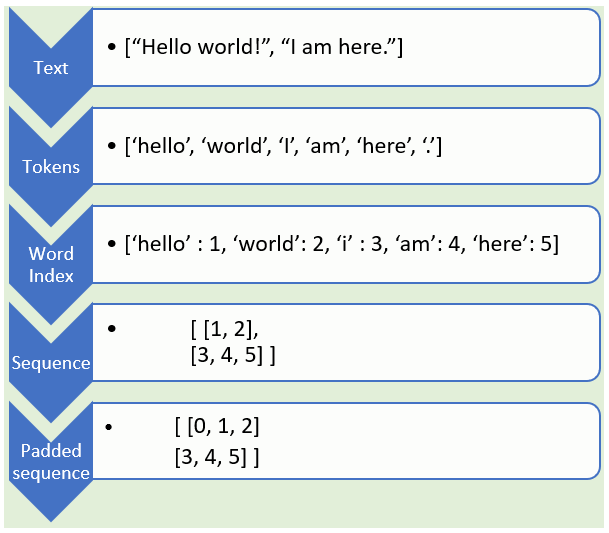

In [ ]:
SOS_token = 0 # fix token for "start of sentence"
EOS_token = 1 # fix token for "end of sentence"
PAD_token = 2 # fix token for "padding"

In [ ]:
class Vocabulary:
    def __init__(self):
        self.SOS_token = 0
        self.EOS_token = 1
        self.PAD_token = 2

        self.word2index = {"[SOS]": 0, "[EOS]": 1, "[PAD]": 2}
        self.index2word = {0: "[SOS]", 1: "[EOS]", 2: "[PAD]"}

        self.num_words = len(self.word2index)     # The number of unique vocabs in your dataset. 
                                                  # This will be input dimension of encoder // output dimension of decoder
        self.longest_sentence = 0                 # Max sequence length of dataset. This will be a seq_len, for your decoder.
        # terminate conidtion while training 

    def add_word(self, word):
        """ add some word to vocab if we have not seen the word. """
        if word not in self.word2index:
            # 1. First entry of word into vocabulary
            self.word2index[word] = self.num_words # 3, 4, 5
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; do nothing
            pass

    def add_sentence(self, sentence, tokenize_func=None):
        if tokenize_func is None:
            tokenize_func = lambda x: x.split(" ")

        # 2. Tokenize the sentence, and add word to vocabulary class one by one
        tokens = tokenize_func(sentence)
        for token in tokens:
            self.add_word(token)
        sentence_len = len(tokens)

        # check the longest sentence
        if sentence_len > self.longest_sentence:
            self.longest_sentence = sentence_len # This is the longest sentence

## Dataset, DataLoader

### Dataset

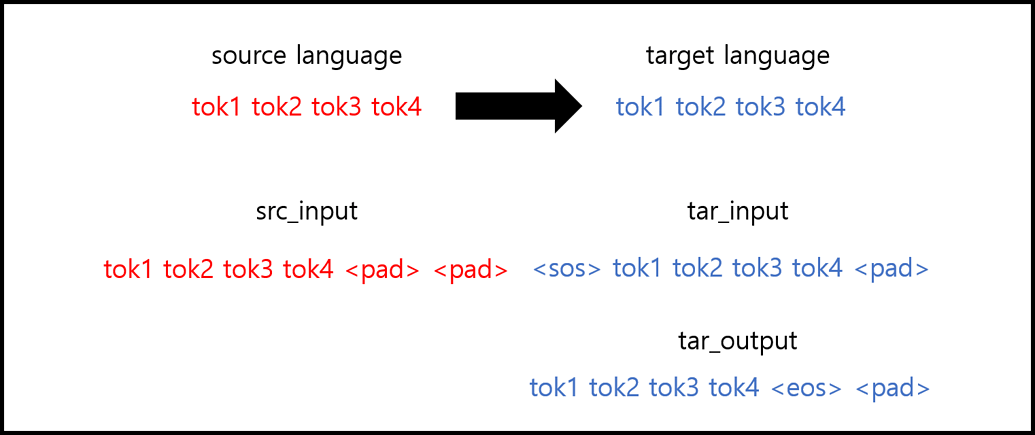

picture from 

https://discuss.pytorch.org/t/my-transformer-model-does-not-work-properly-training-validation-loss-is-increasing/78409

https://towardsdatascience.com/nlp-preparing-text-for-deep-learning-model-using-tensorflow2-461428138657

In [ ]:
from torch.utils.data import Dataset
class s2sDataset(Dataset):
    def __init__(self, data_list, tokenize_func=None):
        super(s2sDataset, self).__init__()
        """
        Args:
            data_list (list): dataset contains sources and targets
            tokenize_func (function): Funtion to tokenize sentence
        Returns:
            None
        """
        self.sources = []
        self.targets = []

        # eng kor -> 2 vocabs
        self.src_vocab = Vocabulary()
        self.trg_vocab = Vocabulary()
        
        if tokenize_func is None:
            self.tokenize_func = lambda x: x.split(" ")
        else:
            self.tokenize_func = tokenize_func

        for (src_sent, trg_sent) in data_list:
            # 1. append lowered sentence to source / target, and add sentence to vocab.
            # lower your sentence -> no upper case 
            src_sent, trg_sent = src_sent.lower(), trg_sent.lower()

            self.sources.append(src_sent)
            self.targets.append(trg_sent)

            self.src_vocab.add_sentence(src_sent)
            self.trg_vocab.add_sentence(trg_sent)

        self.max_seq_length = max(self.src_vocab.longest_sentence, self.trg_vocab.longest_sentence)
        print(f"max sequence length is {self.max_seq_length}")

    def __getitem__(self, index): # 1000 data -> 0~999
        """
        Args:
            index (int): Index
        Returns:
            tuple: (source, target) where target is class_index of the target class. 
        """
        # 2. convert selected source sentence to source indices
        source = [self.src_vocab.word2index[token] for token in self.tokenize_func(self.sources[index])] # from one sentence by extracting it with index

        # 3. add EOS token at the end
        source.append(self.src_vocab.EOS_token)

        #padding
        if len(source) - 2 < self.max_seq_length:
            source.extend([self.src_vocab.PAD_token] * (self.max_seq_length - len(source) + 2))

        source = torch.Tensor(source).long()

        # 2. convert selected source sentence to source indices
        target = [self.trg_vocab.word2index[token] for token in self.tokenize_func(self.targets[index])]
        # 3. add EOS token at the end
        target.append(self.trg_vocab.EOS_token)

        if len(target) - 2 < self.max_seq_length:
            target.extend([self.trg_vocab.PAD_token] * (self.max_seq_length - len(target) + 2))
        target = torch.Tensor(target).long()

        return source, target

    def __len__(self):
        return len(self.sources) # should be equal

In [ ]:
# dataset = s2sDataset(raw, tokenize_func=lambda x: [ch for ch in x])
dataset = s2sDataset(expanded_raw)

max sequence length is 7


In [ ]:
src_ex, trg_ex = dataset.__getitem__(0)

In [ ]:
src_ex

tensor([3, 4, 5, 6, 7, 8, 1, 2, 2])

In [ ]:
print([dataset.src_vocab.index2word[char_idx.item()] for char_idx in src_ex])

['pytorch', 'is', 'very', 'clear', 'to', 'use.', '[EOS]', '[PAD]', '[PAD]']


### DataLoader

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [ ]:
next(iter(trainloader))

[tensor([[3, 4, 5, 6, 7, 8, 1, 2, 2]]), tensor([[3, 4, 5, 6, 1, 2, 2, 2, 2]])]

## Model

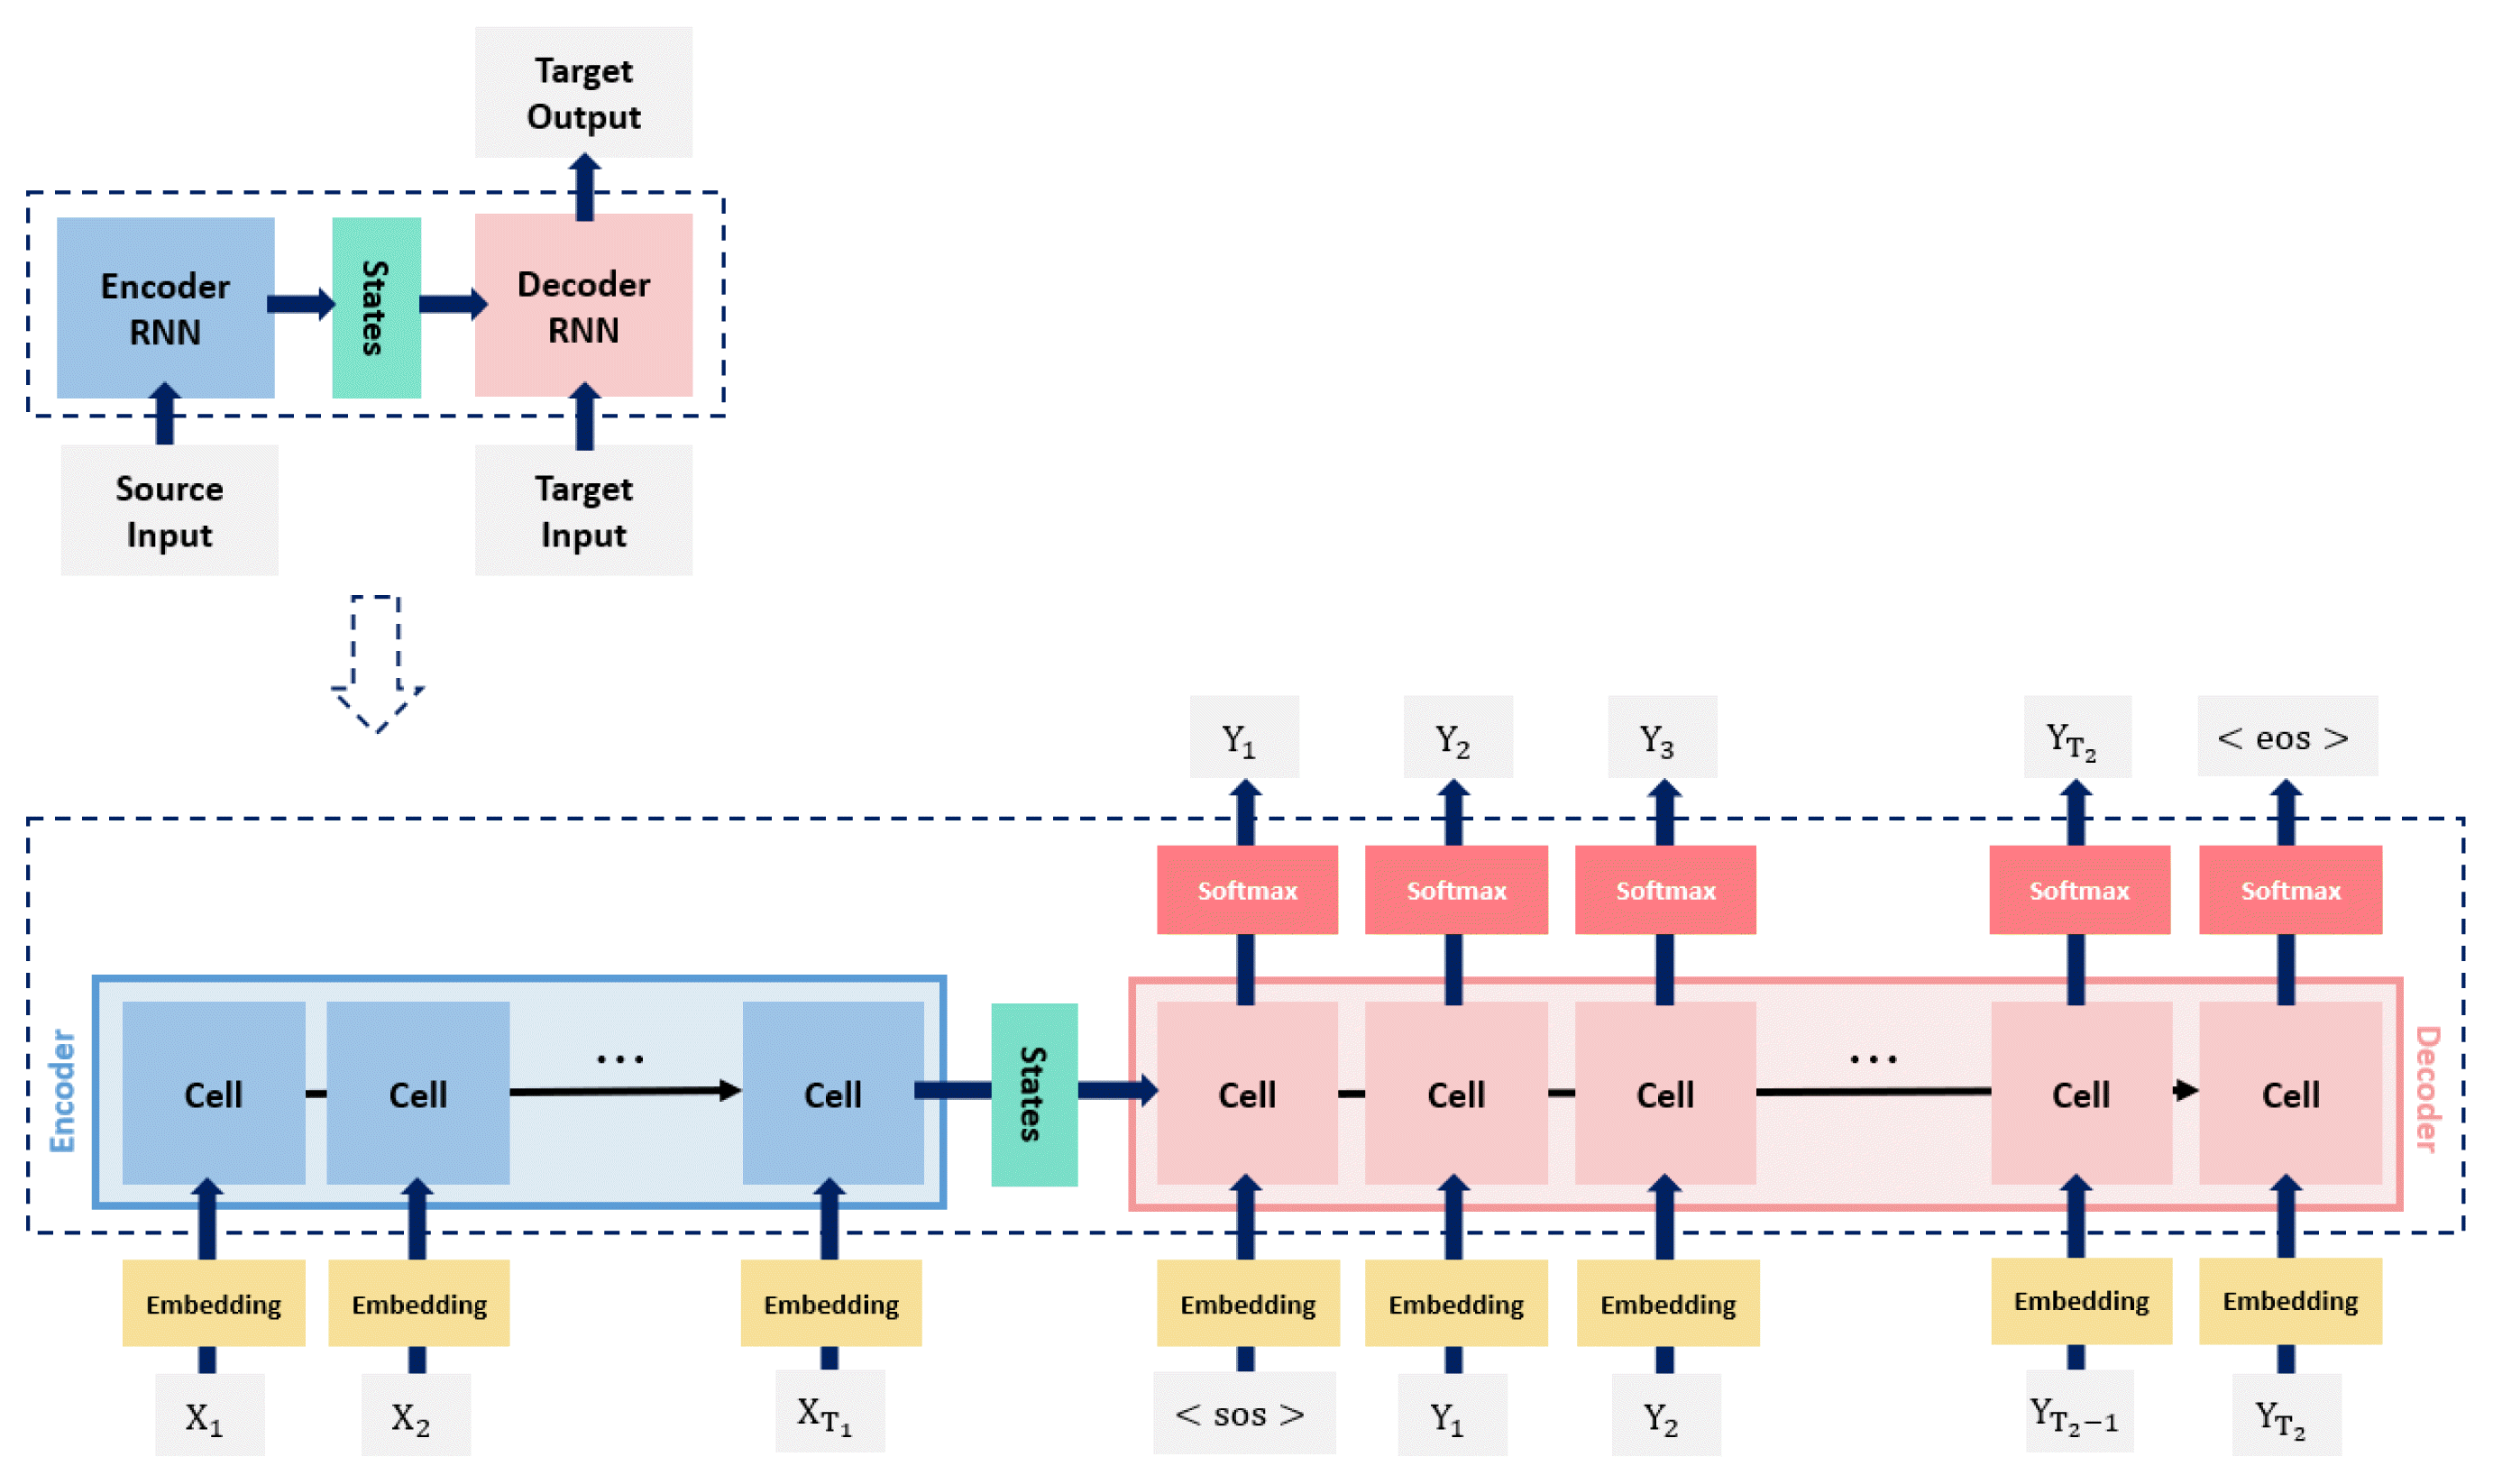

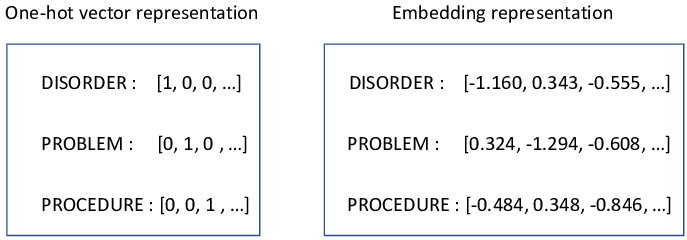

In [ ]:
# king - man + woman = queen

picture from

https://www.e-sciencecentral.org/articles/SC000037416


https://www.researchgate.net/figure/One-hot-vector-representation-and-embedding-representation-for-semantic-tags_fig2_331439739

In [ ]:
# declare simple encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden): # 1, batch
        x = self.embedding(x).view(1, x.size(0), -1) # 1, batch, hidden
        x, hidden = self.gru(x, hidden)
        return x, hidden # [1, batch, hidden], [1, batch, hidden]

In [ ]:
# declare simple decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):  # 1, batch
        x = self.embedding(x).view(1, x.size(0), -1) # 1, batch, hidden
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0]))
        return x, hidden # [batch, output], [1, batch, hidden]

Addtional reference to learn teach forcing

https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/

https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c

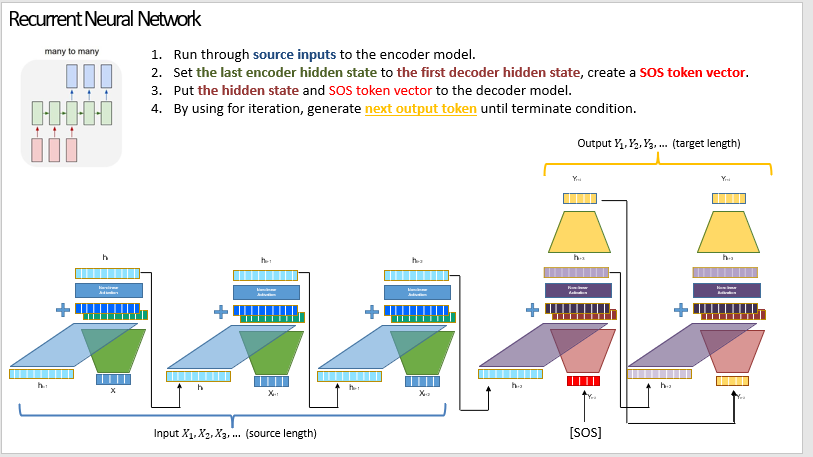

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        batch_size = trg.shape[1]
        trg_len = trg.shape[0] # terminate condition
        trg_vocab_size = self.decoder.output_size
        
        encoder_hidden = torch.zeros([1, batch_size, self.encoder.hidden_size]).to(self.device)
        source_length = src.size(0)

        # 1. Run through source inputs to the encoder model.    
        for enc_idx in range(source_length):
            _, encoder_hidden = self.encoder(src[enc_idx], encoder_hidden) # [1, batch, hidden], [1, batch, hidden]
        
        # 2. Set the last encoder hidden state to the first decoder hidden state, create a SOS token vector.
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        decoder_hidden = encoder_hidden

        #first input to the decoder is the <sos> tokens
        decoder_input = torch.Tensor([[dataset.src_vocab.SOS_token]]).long().to(self.device)

        #to save output from decoder
        outputs = torch.zeros((trg_len, batch_size, trg_vocab_size)).to(self.device)

        # 3. Put the hidden state and SOS token vector to the decoder model.
        # 4. By using for iteration, generate next output token until terminate condition.
        for t in range(0, trg_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t,:,:] = decoder_output # batch, output_size

            # correct (sos) -> wrong (a little) answer -> wrong (a lot) answer -> getting worse and worse
            # teach_force = random.random() < teacher_forcing_ratio

            decoder_input = trg[t] # 1, batch  # teach forcing 100%
            # decoder_input = trg[t] if teach_force else decoder_output.argmax(1)
        
        return outputs

    def predict(self, src, dataset): # sample func in week 11
        batch_size = src.shape[1]
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_hidden = torch.zeros([1, batch_size, self.encoder.hidden_size]).to(device)
        source_length = src.size(0)

        for enc_idx in range(source_length):
            _, encoder_hidden = self.encoder(src[enc_idx], encoder_hidden) # [1, batch, hidden], [1, batch, hidden]
        
        #first input to the decoder is the <sos> tokens
        decoder_input = torch.Tensor([[dataset.src_vocab.SOS_token]]).long().to(device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        # 1. Run through source inputs to the encoder model.    
        # 2. Set the last encoder hidden state to the first decoder hidden state, create a SOS token vector.
        # 3. Put the hidden state and SOS token vector to the decoder model.
        # 4. By using for iteration, generate next output token until terminate condition.
        for _ in range(dataset.trg_vocab.longest_sentence + 1):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden) # [batch, output], [1, batch, hidden]
            
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == dataset.trg_vocab.EOS_token:
                decoded_words.append("[EOS]")
                break
            else:
                decoded_words.append(dataset.trg_vocab.index2word[top_index.item()])

            decoder_input = top_index.detach()
        return decoded_words

In [ ]:
INPUT_DIM = dataset.src_vocab.num_words
OUTPUT_DIM = dataset.trg_vocab.num_words
HID_DIM = 64

enc = Encoder(INPUT_DIM, HID_DIM)
dec = Decoder(HID_DIM, OUTPUT_DIM)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
# src_ex = torch.zeros((32)).long().cuda() # seqlen, batch_size 에서 하나 선택한 상태
# trg_ex = torch.zeros((32)).long().cuda() # seqlen, batch_size 에서 하나 선택한 상태

In [ ]:
# h = torch.zeros([1, 32, 64]).to(device)
# print(enc(src_ex, h)[0].shape, enc(src_ex, h)[1].shape)

In [ ]:
# h = torch.zeros([1, 32, 64]).to(device)
# print(dec(trg_ex, h)[0].shape, dec(trg_ex, h)[1].shape)

In [ ]:
# model(src_ex, trg_ex).shape

## Train & Evaluate

In [ ]:
def train(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(dataloader):
        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src, trg = src.transpose(0, 1).to(device), trg.transpose(0, 1).to(device)
        model.zero_grad()
        
        output = model(src, trg, 1)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output.reshape(-1, output_dim)
        trg = trg.reshape(-1)

        #trg = [trg len * batch size]
        #output = [trg len * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip) # prevents exploding / vanishing
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr = 0.01)
criterion = nn.NLLLoss(ignore_index=2) # nn.LogSoftmax

In [ ]:
# i go to school [eos] [pad] [pad] [pad]
# 나는 학교에 갔다 [eos] [pad] [pad]...

In [ ]:
N_EPOCHS = 10 # 10 * 250
CLIP = 1

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, trainloader, optimizer, criterion, CLIP)
    if (epoch + 1) % 2 == 0:
        print(f'Epoch: {epoch+1:02}')   
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

Epoch: 02
	Train Loss: 0.001 | Train PPL:   1.001
Epoch: 04
	Train Loss: 0.000 | Train PPL:   1.000
Epoch: 06
	Train Loss: 0.000 | Train PPL:   1.000
Epoch: 08
	Train Loss: 0.000 | Train PPL:   1.000
Epoch: 10
	Train Loss: 0.000 | Train PPL:   1.000


In [ ]:
for i in range(10):# 예시
    src_ex, trg_ex = dataset.__getitem__(i)
    src_ex, trg_ex = src_ex.to(device), trg_ex.to(device)
    decoded_words = model.predict(src_ex.unsqueeze(1), dataset) 

    print(' '.join([dataset.src_vocab.index2word[char_idx.item()] for char_idx in src_ex]))
    print(' '.join([dataset.trg_vocab.index2word[char_idx.item()] for char_idx in trg_ex]))
    print(' '.join([word for word in decoded_words]))

    print("*" * 50)

pytorch is very clear to use. [EOS] [PAD] [PAD]
파이토치는 사용하기 매우 직관적이다. [EOS] [PAD] [PAD] [PAD] [PAD]
파이토치는 사용하기 매우 직관적이다. [EOS]
**************************************************
i feel hungry. [EOS] [PAD] [PAD] [PAD] [PAD] [PAD]
나는 배가 고프다. [EOS] [PAD] [PAD] [PAD] [PAD] [PAD]
나는 배가 고프다. [EOS]
**************************************************
pytorch is a framework for deep learning. [EOS] [PAD]
파이토치는 딥러닝을 위한 프레임워크이다. [EOS] [PAD] [PAD] [PAD] [PAD]
파이토치는 딥러닝을 위한 프레임워크이다. [EOS]
**************************************************
pytorch is a framework for deep learning. [EOS] [PAD]
파이토치는 딥러닝을 위한 프레임워크이다. [EOS] [PAD] [PAD] [PAD] [PAD]
파이토치는 딥러닝을 위한 프레임워크이다. [EOS]
**************************************************
i feel hungry. [EOS] [PAD] [PAD] [PAD] [PAD] [PAD]
나는 배가 고프다. [EOS] [PAD] [PAD] [PAD] [PAD] [PAD]
나는 배가 고프다. [EOS]
**************************************************
science is very easy. [EOS] [PAD] [PAD] [PAD] [PAD]
과학은 매우 쉽다. [EOS] [PAD] [PAD] [PAD] [PAD] [PAD]
과학은 매우 쉽다. [EOS]
*

# Part2. seq2seq model with word-level RNN, real data

Dataset from : https://www.manythings.org/anki/

In [ ]:
!wget https://www.manythings.org/anki/kor-eng.zip
!unzip kor-eng.zip

--2020-11-25 04:08:35--  https://www.manythings.org/anki/kor-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143403 (140K) [application/zip]
Saving to: ‘kor-eng.zip.1’

kor-eng.zip.1       100%[===================>] 140.04K   315KB/s    in 0.4s    

2020-11-25 04:08:36 (315 KB/s) - ‘kor-eng.zip.1’ saved [143403/143403]

Archive:  kor-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: _about.txt              
  inflating: kor.txt                 


In [ ]:
with open("kor.txt", "r") as f:
    corpus  = f.readlines() # [sent, sent, sent]

In [ ]:
raw = []
for text in corpus:
    en_kor_pairs = text.split("\t")[:2]
    raw.append(en_kor_pairs)

In [ ]:
len(raw)

3642

In [ ]:
raw[-2:]

[["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
  '만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어민이 아니라고 깨닫게 해주는 뭔가를 네 말 속에서 캐치해 낸 것이겠지. 다르게 표현하자면 넌 원어민처럼 말하지 않아.'],
 ['Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people, and out of the few hundred that there are but a dozen or less whom he knows intimately, and out of the dozen, one or two friends at most, it will easily be seen, when we remember the number of millions who inhabit this world, that probably, since the earth was created, the right man has never yet met the right woman.',
  '의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지. 그런데 인간이 수

## Build Vocabulary

In [ ]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
import numpy as np
import time
from datetime import datetime
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset, DataLoader

### Dataset

In [ ]:
dataset = s2sDataset(raw)

max sequence length is 101


### DataLoader

In [ ]:
# train / valid

## Model

## Train & Evaluate

In [ ]:
def train():

SyntaxError: ignored

In [ ]:
def evaluate(): # evaluate by valid loader

    return epoch_loss / len(dataloader)

## Run

In [ ]:
for i in train_idx[:10]:# 예시
    src_ex, trg_ex = dataset.__getitem__(i)
    src_ex, trg_ex = src_ex.to(device), trg_ex.to(device)
    decoded_words = model.predict(src_ex.unsqueeze(1), dataset) 

    print(' '.join([dataset.src_vocab.index2word[char_idx.item()] for char_idx in src_ex]))
    print(' '.join([dataset.trg_vocab.index2word[char_idx.item()] for char_idx in trg_ex]))
    print(' '.join([word for word in decoded_words]))

    print("*" * 50)